When you run this code, **SKIP THE FIRST WHOLE SECTION**

The second section creates the covariate matrix and response vector that we need for linear regression and later logistic regression

The third section performs the linear regression for batch 1

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict
from pathlib import Path
import pandas as pd

In [2]:
from src.data.embedding import Embedder

In [3]:
import sys
sys.path.append('..') # add the parent directory to system path
from src.data.dataset import CnvDataset

# Testing (skip this whole section)

### Test embedding matrices (skip)

In [21]:
# Example setup: Generate a mock input matrix
# Rows: [one-hot encoding (4 rows for A, T, G, C), CNV loss, CNV gain, open chromatin]
# Columns: Nucleotide positions (e.g., 6000 columns for 6k bp)
np.random.seed(42)  # For reproducibility
n_positions = 6000
mock_matrix = np.random.randint(0, 2, size=(7, n_positions))

In [22]:
print(mock_matrix.shape) # a random matrix of 0 and 1
print(mock_matrix)

(7, 6000)
[[0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 0 ... 1 1 0]
 [1 1 0 ... 1 1 1]
 [1 1 0 ... 0 1 0]]


In [23]:
mock_matrix1 = np.zeros((7, 6000))
mock_matrix1[1, :] = np.ones(6000)
mock_matrix1[-1, :] = 3* np.ones(6000)
mock_matrix1[-2, :] = 4* np.ones(6000)
mock_matrix1[-3, :] = 5* np.ones(6000)
mock_matrix1

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [4., 4., 4., ..., 4., 4., 4.],
       [3., 3., 3., ..., 3., 3., 3.]])

### Agregation function

In [32]:
def aggregate_matrix(matrix, tss_position=2000):
    """
    Create a dataset that combines codon frequencies and aggregated CNV/open chromatin metrics.

    Args:
        matrix (numpy.ndarray): The embedding matrix.
        tss_position (int): The starting position for codon counting (default is 1).

    Returns:
        numpy.ndarray: A 1-row dataset with 64 columns for codon counts and 3 columns for CNV/open chromatin metrics.
    """
    # Extract one-hot DNA rows (first 4 rows: A, T, G, C)
    nucleotides = ['A', 'T', 'G', 'C']
    one_hot_dna = matrix[:4, :]

    # Decode one-hot to nucleotide sequence
    sequence = ''.join(
        nucleotides[np.argmax(one_hot_dna[:, i])]
        for i in range(one_hot_dna.shape[1])
    )

    # Start codon counting from the TSS
    start = tss_position - 1
    codons = [
        sequence[i:i + 3]
        for i in range(start, len(sequence), 3)
        if i + 3 <= len(sequence)
    ]

    # Generate all 64 possible codons
    possible_codons = [a + b + c for a in nucleotides for b in nucleotides for c in nucleotides]

    # Count codon frequencies
    codon_counts = Counter(codons)

    # Ensure all 64 codons are represented in the output (with count 0 if absent)
    codon_counts_array = np.array([codon_counts.get(codon, 0) for codon in possible_codons])

    # Extract CNV and open chromatin rows (last 3 rows)
    cnv_loss = matrix[4, :] #TODO do we take the average across all embedding or also from TSS??
    cnv_gain = matrix[5, :]
    open_chromatin = matrix[6, :]

    # Compute averages
    cnv_loss_avg = np.mean(cnv_loss)
    cnv_gain_avg = np.mean(cnv_gain)
    open_chromatin_avg = np.mean(open_chromatin)

    # Combine codon frequencies and aggregated metrics into one dataset
    aggregated_values = np.array([cnv_loss_avg, cnv_gain_avg, open_chromatin_avg])
    final_dataset = np.concatenate([codon_counts_array, aggregated_values])

    # Create column headings
    codon_headings = possible_codons
    aggregated_headings = ['cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']
    column_headings = codon_headings + aggregated_headings

    return final_dataset, column_headings


In [ ]:
def aggregate_matrix_fast(matrix, tss_position=2000):
    """
    Create a dataset that combines codon frequencies and aggregated CNV/open chromatin metrics.
    
    Args:
        matrix (numpy.ndarray): The embedding matrix.
        tss_position (int): The starting position for codon counting (default is 2000).
    
    Returns:
        numpy.ndarray: A 1-row dataset with 64 columns for codon counts and 3 columns for CNV/open chromatin metrics.
    """
    nucleotides = np.array(['A', 'T', 'G', 'C'])
    
    # Extract one-hot DNA rows and decode to sequence efficiently
    sequence = nucleotides[np.argmax(matrix[:4, :], axis=0)]
    
    # Compute valid codon start positions
    start = tss_position - 1
    sequence_length = len(sequence)
    
    # Use NumPy slicing for codon extraction
    valid_indices = np.arange(start, sequence_length - 2, 3)
    codons = np.char.add(np.char.add(sequence[valid_indices], sequence[valid_indices + 1]), sequence[valid_indices + 2])
    
    # Generate all possible codons
    possible_codons = np.array([a + b + c for a in nucleotides for b in nucleotides for c in nucleotides])
    
    # Count occurrences using np.unique
    unique_codons, counts = np.unique(codons, return_counts=True)
    codon_counts = dict(zip(unique_codons, counts))
    
    # Create a codon frequency array
    codon_counts_array = np.array([codon_counts.get(codon, 0) for codon in possible_codons], dtype=int)

    # Normalize counts
    total = np.sum(codon_counts_array)
    if total != 0: # Avoid division by 0
        codon_counts_array = codon_counts_array / total  # Normalize
    
    # Extract CNV and open chromatin rows
    cnv_loss = matrix[4, :]
    cnv_gain = matrix[5, :]
    open_chromatin = matrix[6, :]
    
    # Compute averages
    cnv_loss_avg = np.mean(cnv_loss)
    cnv_gain_avg = np.mean(cnv_gain)
    open_chromatin_avg = np.mean(open_chromatin)
    
    # Combine features
    aggregated_values = np.array([cnv_loss_avg, cnv_gain_avg, open_chromatin_avg])
    final_dataset = np.concatenate([codon_counts_array, aggregated_values])
    
    # Column names
    codon_headings = possible_codons.tolist()
    aggregated_headings = ['cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']
    column_headings = codon_headings + aggregated_headings
    
    return final_dataset, column_headings


### Tests for aggregate matrix (skip)

In [29]:
final_dataset, column_headings = aggregate_matrix_fast(mock_matrix)
print(final_dataset)
print(column_headings)

[0.18379595 0.07126782 0.04876219 0.01650413 0.07951988 0.03975994
 0.024006   0.01350338 0.03675919 0.01350338 0.00825206 0.00450113
 0.01500375 0.00975244 0.00525131 0.         0.07351838 0.03450863
 0.01350338 0.01050263 0.04126032 0.01425356 0.00375094 0.0060015
 0.01650413 0.01125281 0.00225056 0.00075019 0.01050263 0.00450113
 0.00150038 0.00150038 0.03900975 0.01425356 0.00750188 0.00900225
 0.01050263 0.0060015  0.00450113 0.         0.00900225 0.00375094
 0.00075019 0.00075019 0.00300075 0.00075019 0.         0.00075019
 0.01950488 0.00825206 0.00375094 0.00450113 0.00975244 0.00525131
 0.00150038 0.         0.00750188 0.00825206 0.00150038 0.00150038
 0.00150038 0.00150038 0.         0.         0.5015     0.50916667
 0.49933333]
['AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC'

In [34]:
final_dataset, column_headings = aggregate_matrix_fast(mock_matrix1)
print(final_dataset)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 4. 3.]


### Load data: gene positions and classification

Import dataset of gene positions (ignore)

Import classification dataset

In [19]:
class_path = 'data/splits/batch1_test_filtered.tsv'
classification_df = pd.read_csv(class_path, sep="\t")
classification_df

,barcode,gene_id,expression_count,classification
0,AAACCGAAGGCGCATC-1,ENSG00000269113,0.825470,low
1,AAACCGAAGGCGCATC-1,ENSG00000231252,0.495597,low
2,AAACCGAAGGCGCATC-1,ENSG00000188641,0.495597,low
3,AAACCGAAGGCGCATC-1,ENSG00000265972,1.271419,high
4,AAACCGAAGGCGCATC-1,ENSG00000197956,0.495597,low
...,...,...,...,...
18630,TTTAGGATCGTTATCT-1,ENSG00000198938,1.444938,high
18631,TTTAGGATCGTTATCT-1,ENSG00000198840,1.768557,high
18632,TTTAGGATCGTTATCT-1,ENSG00000198886,0.963478,high
18633,TTTAGGATCGTTATCT-1,ENSG00000198786,0.963478,high


In [11]:
import pandas as pd
from collections import defaultdict


# Initialize dictionary
barcode_dict = defaultdict(list)

# Populate dictionary
for barcode, gene_id in zip(classification_df.iloc[:, 0], classification_df.iloc[:, 1]):
    barcode_dict[barcode].append(gene_id)

# Convert defaultdict to a regular dictionary
barcode_dict = dict(barcode_dict)


In [15]:
gene_ids = classification_df[classification_df.iloc[:, 0] == 'TTTGTTGGTGGCTTCC-1'].iloc[:, 1]
print(gene_ids)

347621    ENSG00000269113
347622    ENSG00000188641
347623    ENSG00000265972
347624    ENSG00000231424
347625    ENSG00000196352
               ...       
347719    ENSG00000129682
347720    ENSG00000198712
347721    ENSG00000198899
347722    ENSG00000198786
347723    ENSG00000198727
Name: gene_id, Length: 103, dtype: object


In [13]:
barcode_dict['TTTGTTGGTGGCTTCC-1']

['ENSG00000269113',
 'ENSG00000188641',
 'ENSG00000265972',
 'ENSG00000231424',
 'ENSG00000196352',
 'ENSG00000172554',
 'ENSG00000115738',
 'ENSG00000055813',
 'ENSG00000071073',
 'ENSG00000153208',
 'ENSG00000231969',
 'ENSG00000157827',
 'ENSG00000162989',
 'ENSG00000144290',
 'ENSG00000236283',
 'ENSG00000081479',
 'ENSG00000115896',
 'ENSG00000231304',
 'ENSG00000170293',
 'ENSG00000241684',
 'ENSG00000269028',
 'ENSG00000144847',
 'ENSG00000069849',
 'ENSG00000085276',
 'ENSG00000229102',
 'ENSG00000272620',
 'ENSG00000249631',
 'ENSG00000248049',
 'ENSG00000138744',
 'ENSG00000138756',
 'ENSG00000163297',
 'ENSG00000145284',
 'ENSG00000138639',
 'ENSG00000118785',
 'ENSG00000184305',
 'ENSG00000287292',
 'ENSG00000145416',
 'ENSG00000151726',
 'ENSG00000145536',
 'ENSG00000112902',
 'ENSG00000145687',
 'ENSG00000172348',
 'ENSG00000164418',
 'ENSG00000111885',
 'ENSG00000164674',
 'ENSG00000197461',
 'ENSG00000106415',
 'ENSG00000048052',
 'ENSG00000158321',
 'ENSG00000235139',


In [36]:
classification_lookup = classification_df.set_index(['gene_id', 'barcode'])[['expression_count', 'classification']].to_dict(orient='index')
classification_lookup

{('ENSG00000269113', 'AAACAGCCACAATACT-1'): {'expression_count': 1.5382726,
  'classification': 'high'},
 ('ENSG00000172260', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000188641', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000265972', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000230426', 'AAACAGCCACAATACT-1'): {'expression_count': 1.5382726,
  'classification': 'high'},
 ('ENSG00000266028', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000163219', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000071073', 'AAACAGCCACAATACT-1'): {'expression_count': 1.2348006,
  'classification': 'high'},
 ('ENSG00000162989', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000236283', 'AAACAGCCACAATACT-1'): {'expression_coun

Sets of genes and cells that were preprocessed

In [20]:
barcode_set = set(classification_df['barcode'])
gene_set = set(classification_df['gene_id'])

In [39]:
len(barcode_set)

13677

We have to make sure that the barcodes are also in the epiAneufinder file

In [5]:
cnv_path = 'preprocessing/Multiome/epiAneufinder.tsv'
epiAneu_df = pd.read_csv(cnv_path, sep='\t')

In [7]:
column_names_str = str(epiAneu_df.columns.to_list()[0])
column_names_list = column_names_str.split(' ')
column_names_list = column_names_list[4:]
cleaned_list = [item.lstrip("cell-") for item in column_names_list]

In [8]:
filtered_class_df = classification_df[classification_df["barcode"].isin(cleaned_list)]
filtered_class_df

,barcode,gene_id,expression_count,classification
423,AAACCGAAGGCGCATC-1,ENSG00000269113,0.825470,low
424,AAACCGAAGGCGCATC-1,ENSG00000231252,0.495597,low
425,AAACCGAAGGCGCATC-1,ENSG00000188641,0.495597,low
426,AAACCGAAGGCGCATC-1,ENSG00000265972,1.271419,high
427,AAACCGAAGGCGCATC-1,ENSG00000197956,0.495597,low
...,...,...,...,...
347616,TTTGTTGGTGCCGCAA-1,ENSG00000198938,2.220852,high
347617,TTTGTTGGTGCCGCAA-1,ENSG00000198840,1.968703,high
347618,TTTGTTGGTGCCGCAA-1,ENSG00000198886,1.116385,high
347619,TTTGTTGGTGCCGCAA-1,ENSG00000198786,1.406267,high


In [8]:
column_names_list1 = []
for cell in column_names_list:
    column_names_list1.append(cell.strip('cell-'))

print(column_names_list1)

['GCGCAATGTTGCGGAT-3', 'CTAGTGAGTCACCTAT-3', 'AATCATGTCGATCAGT-1', 'TCCTTAGTCGGGACTC-4', 'ACTATCCGTCTAACCT-1', 'GTGCACGGTCACAAAT-3', 'TACGTAATCGTTTCGC-3', 'ATTGGTTCACATTGCA-1', 'TACCTCATCGAAGTAG-2', 'GTCTTGCTCCTGTTCA-4', 'TAGCGGCTCAATGTGC-1', 'CCGTTATGTTAGCCAA-2', 'GTGCTCAAGGTTACAC-3', 'TTAAGGACATCGCTTT-3', 'CTAAGTCAGTTGGCCA-3', 'GCAGGTGAGCGAGCGA-3', 'ATCACAATCGCCTGTT-2', 'TGAGGAGGTAAACAAG-3', 'AATCCCTGTACCGAAC-4', 'GAGTTGCGTCAATACG-3', 'CTTGTTCCACAATTAC-4', 'ATCGAGGCAGAAACGT-2', 'TCGTTAAAGCCGCAGT-1', 'CGGTGAGAGCATTAGC-1', 'AAGCAAGTCCAGCACA-4', 'CTGCAATAGACAACAG-2', 'GGATGTAAGGGATGAC-3', 'GTCCAGGGTATACTGG-3', 'CTTTGGGAGTTGCGTG-4', 'TTAGACTCAGCTAATT-4', 'GGAGTCTGTCGCGCAA-4', 'TAGCAGGCAAGGTAAC-2', 'CTAATGTCAATTTGGT-4', 'ACGAAGTCAGACAAAC-1', 'TTCATTCAGTGCTGTG-4', 'AAGGTGCAGCCTGACA-3', 'TCCTCACAGTCATTAG-3', 'TCCTTGCAGGAAGCTA-3', 'TTGCAAGGTAATCGTG-3', 'ATCAGGTTCATTTGTC-2', 'CTCTTGATCCTTGAGG-4', 'AGTCAAGAGTGTTGCG-2', 'CTTACCTCATCCATCT-3', 'AGCAAATAGCCTGGTA-4', 'CACCTCAGTAATTAGC-3', 'CGGCTAAT

In [15]:
# Filter the set to keep only elements also in the list
barcode_set_filtered = barcode_set.intersection(column_names_list1)
barcode_set_filtered

{'GTAGGCGAGCATGTCG-1',
 'CACAAGCGTACCTTAC-3',
 'CCGCTAGCAACAGCCT-4',
 'TGCATCCTCCCTCAAC-4',
 'GGACATAAGCGAAGTA-4',
 'CGGTTATAGGAGTCGG-3',
 'GTTCTTGTCCCGCATT-3',
 'GATCGAGCATTGCAGC-3',
 'CGGTTATAGTTGTCCC-3',
 'TTGTAAGTCATTGACA-4',
 'TCAGTGAGTACGGTAC-3',
 'GTAGTTTCAACAGGTG-4',
 'CTTGTAAAGGAAGCTA-1',
 'GCCCATAAGGAGGTTA-4',
 'AGCACTTAGTAAACCC-3',
 'TACGCTTGTCTAACAG-3',
 'TGGACCGGTAGCTAGC-4',
 'GCCTACTTCAATGTGC-4',
 'TTCAACCGTCAATACG-2',
 'TGAGCACGTCTTGCAT-1',
 'AGCGGACCATTGGGAG-4',
 'GGACGAAGTCATGAGC-4',
 'GGTCAATTCCCTTGCG-3',
 'TCGTAATCATTGTGAT-4',
 'TGAGGAGGTACCGAAC-1',
 'CCCAAACCACTGGCTG-3',
 'AGAGAGGAGAGAAGGG-3',
 'CGATATTCACGAATCC-4',
 'CAGCTCAAGGAGCAAC-4',
 'CAATGTGGTCCTTTAA-4',
 'TGTTATGAGCACGATT-4',
 'AAATCCGGTCCTAATC-3',
 'TAGCTTAAGCCATCAG-4',
 'GGATGGCCACCATATG-4',
 'CTGGTCAAGAATCTCA-4',
 'GGTTGAGCAAGCCAGA-1',
 'CAGCAAGCATAATTGC-1',
 'TTGCTTTAGTACTGGT-3',
 'GCTCCTTAGGGCTTAT-1',
 'CTTAGTTTCGCAATCG-2',
 'TTTGTTGGTTGAGGTC-3',
 'GCTAAGAAGACTAAGG-1',
 'CGGTTGGGTTAGCGTA-4',
 'TAGGTTGGT

In [5]:
def adjust_barcode_names_for_embedding(barcode_set):
    output_set = set()
    barcode_list = list(barcode_set)
    for b in barcode_list:
        b_string = str(b)
        output_set.add('cell-' + b_string)

    return output_set

In [6]:
def create_input_sets(classification_df, epiAneu_df):

    # Set of barcode and genes from classification df
    barcode_set = set(classification_df['barcode'])
    gene_set = set(classification_df['gene_id'])

    # Fix names of barcodes in the set
    barcode_set = adjust_barcode_names_for_embedding(barcode_set)
    
    # List of barcodes in epiAneufinder
    column_names_str = str(epiAneu_df.columns.to_list()[0])
    column_names_list = column_names_str.split(' ')
    column_names_list = column_names_list[4:]

    # Filter the set to keep only elements also in the list
    barcode_set_filtered = barcode_set.intersection(column_names_list)
    barcode_set_filtered

    return barcode_set_filtered, gene_set

In [29]:
barcode_set_filtered, gene_set =create_input_sets(classification_df, epiAneu_df)

In [30]:
print(barcode_set_filtered)
print(len(barcode_set_filtered))
print(gene_set)
print(len(gene_set))

{'cell-AATTACCCAGCAAGTG-1', 'cell-CGTTAGGTCGAGGAGT-1', 'cell-AGTTGCGTCGATATTG-1', 'cell-CTGTTAAAGGTTACGT-1', 'cell-CTATTCAGTGGTGAGA-1', 'cell-CGGTGAGAGCATTAGC-1', 'cell-TCCATTGTCTATGACA-1', 'cell-CCGTTACTCGTAACGT-1', 'cell-GAAGGAACAGGTTCAC-1', 'cell-ACCTACCTCGGCTAGC-1', 'cell-ACCCTGTTCATAGCCG-1', 'cell-ACTATCCGTTTAACGG-1', 'cell-CACCGGTAGTCCTTCA-1', 'cell-GCTAAGTTCGGGCCAT-1', 'cell-GTATGTTCATAAAGCA-1', 'cell-CATTATCTCGCGACAC-1', 'cell-ACCTTCCAGTAGCTTA-1', 'cell-AGCCAGTGTGCTTAGA-1', 'cell-TGATGAACAAGGCCAA-1', 'cell-CATCCTCAGGAGCAAC-1', 'cell-GTAATAGCAACTAGGG-1', 'cell-AGCCGCTAGAATGACG-1', 'cell-ATCACACAGTTTCCGC-1', 'cell-CAACAATGTCAACAAT-1', 'cell-GGATGAATCCTGATTT-1', 'cell-TGAACAGAGCACTTGG-1', 'cell-CTATGGCCAGACAAAC-1', 'cell-GCCTTTATCTAATTGG-1', 'cell-TGGACCGGTGTGCAAC-1', 'cell-ACACTAATCCGTTAAA-1', 'cell-GCATATATCGTTTCTG-1', 'cell-GGACCGAAGCGATAAG-1', 'cell-TGTGTTAAGAGAAGGG-1', 'cell-GTGCACGGTGTCCAAA-1', 'cell-GTTACCTGTTAGGCTA-1', 'cell-GTGCGGTTCTCGACCT-1', 'cell-AACAGATAGGTCAAAG-1', 

### Test data (skip)

In [35]:
#Last 100 elements of the dataset
class_df_test = classification_df.iloc[27353895:27353995]
barcode_set_testing = set(class_df_test['barcode'])
genes_set_testing = set(class_df_test['gene_id'])
print(barcode_set_testing)
print(genes_set_testing)

{'TTTGTTGGTTGAGGTC-3'}
{'ENSG00000241743', 'ENSG00000198712', 'ENSG00000226679', 'ENSG00000011201', 'ENSG00000102271', 'ENSG00000278847', 'ENSG00000068366', 'ENSG00000236091', 'ENSG00000078596', 'ENSG00000101846', 'ENSG00000156298', 'ENSG00000100311', 'ENSG00000165583', 'ENSG00000283697', 'ENSG00000234688', 'ENSG00000286326', 'ENSG00000230668', 'ENSG00000147113', 'ENSG00000160219', 'ENSG00000077279', 'ENSG00000225689', 'ENSG00000182162', 'ENSG00000280870', 'ENSG00000012817', 'ENSG00000212907', 'ENSG00000188511', 'ENSG00000260683', 'ENSG00000169306', 'ENSG00000286050', 'ENSG00000198763', 'ENSG00000227042', 'ENSG00000198804', 'ENSG00000013619', 'ENSG00000227610', 'ENSG00000233103', 'ENSG00000100362', 'ENSG00000183878', 'ENSG00000198888', 'ENSG00000147010', 'ENSG00000100336', 'ENSG00000198947', 'ENSG00000089472', 'ENSG00000235111', 'ENSG00000189108', 'ENSG00000099725', 'ENSG00000286381', 'ENSG00000129824', 'ENSG00000176728', 'ENSG00000228253', 'ENSG00000228343', 'ENSG00000231535', 'ENSG00

### Create a merged dataset (skip)

Match the datasets by the gene_ids

In [9]:
# Merge the datasets based on the gene_id column
merged_df = pd.merge(
    classification_df, gene_df,
    on="gene_id",  # Match rows based on this column
    how="inner"    # Keep only rows with matches in both datasets
)

# Display the result
print(merged_df)

                     barcode          gene_id  expression_count  \
0         AAACAGCCAAACGCGA-2  ENSG00000235146          0.000000   
1         AAACAGCCAAACGCGA-2  ENSG00000187634          0.240150   
2         AAACAGCCAAACGCGA-2  ENSG00000187583          0.000000   
3         AAACAGCCAAACGCGA-2  ENSG00000205231          0.000000   
4         AAACAGCCAAACGCGA-2  ENSG00000228750          0.000000   
...                      ...              ...               ...   
26697499  TTTGTTGGTTGAGGTC-3  ENSG00000212907          1.068847   
26697500  TTTGTTGGTTGAGGTC-3  ENSG00000198886          1.907476   
26697501  TTTGTTGGTTGAGGTC-3  ENSG00000198786          1.573612   
26697502  TTTGTTGGTTGAGGTC-3  ENSG00000198727          3.001725   
26697503  TTTGTTGGTTGAGGTC-3  ENSG00000273554          0.000000   

         classification    start      end  
0                  zero   587577   595116  
1                   low   923923   944575  
2                  zero   966482   975865  
3                  

For testing we use first 1000 rows

In [10]:
merged_df_testing = merged_df.head(0)
barcode_set_testing = set(merged_df_testing['barcode'])
genes_set_testing = set(merged_df_testing['gene_id'])
print(barcode_set_testing)

{'AAACAGCCAAACGCGA-2'}


### Import the embedding

We get the embedding matrix as an input with following rows:
- 4 rows for one-hot-encoding
- CNV loss
- CNV gain
-open chromatin

In [21]:
# Add your own path
fasta_path = 'data/reference/GRCh38.d1.vd1.fa'
atac_path = 'data/overlap_genes_peaks.tsv' 
cnv_path = 'out/epiAneufinder/epiAneuFinder_results.tsv'

In [29]:
embedder = embed(
	fasta_path,
	atac_path,
	cnv_path,
	gene_set=gene_set,
	barcode_set=barcode_set,
	mode='single_gene_barcode'
)

[embed]: Computing embeddings (# genes done):   0%|                                            | 0/1024 [06:29<?, ?it/s]


In [26]:
_, _, matrix = next(embedder)
print(np.array(matrix).shape)

(7, 10000)


In [28]:
len(matrix[4, :])


10000

In [30]:
list_mean_loss = []
for barcode, gene, matrix in embedder:
    row_loss = matrix[4, :]
    list_mean_loss.append(np.mean(row_loss))

[embed]: Iterating over all possible barcode-gene combinations
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 102 barcodes
[embed]: Using 1024 genes


[embed]: Computing embeddings (# genes done): 100%|█████████████████████████████████| 1024/1024 [05:29<00:00,  3.11it/s]


In [32]:
# Get unique values in the selected column
unique_values = np.unique(list_mean_loss)

# Count of unique values
num_unique_values = unique_values.size

print("Unique values:", unique_values)
print("Number of unique values:", num_unique_values)

Unique values: [0.]
Number of unique values: 1


# Create the covariate matrix and the response vector

We will have a **matrix X** that has per pair (cell_barcode, gene_id) a row of 67 inputs: 64 are the counts of the triplets and 3 are the averages of open cromatine, cnv gain, cnv loss over the nucleotides

There will be 2 **response vectors**:
- y1: has expression counts per pair (cell_barcode, gene_id)
- y2: classification of expression per pair (cell_barcode, gene_id)

Slow function: for 1 barcode and 100 genes it neads 5min

In [4]:
def aggregate_matrix_fast(matrix):
    """
    Create a dataset that combines codon frequencies and aggregated CNV/open chromatin metrics.
    
    Args:
        matrix (numpy.ndarray): The embedding matrix.
        tss_position (int): The starting position for codon counting (default is 2000).
    
    Returns:
        numpy.ndarray: A 1-row dataset with 64 columns for codon counts and 3 columns for CNV/open chromatin metrics.
    """
    nucleotides = np.array(['A', 'T', 'G', 'C'])
    
    # Extract one-hot DNA rows and decode to sequence efficiently
    sequence = nucleotides[np.argmax(matrix[:4, :], axis=0)]
    
    # Compute valid codon start positions
    start = 2000 - 1
    sequence_length = len(sequence)
    
    # Use NumPy slicing for codon extraction
    valid_indices = np.arange(start, sequence_length - 2, 3)
    codons = np.char.add(np.char.add(sequence[valid_indices], sequence[valid_indices + 1]), sequence[valid_indices + 2])
    
    # Generate all possible codons
    possible_codons = np.array([a + b + c for a in nucleotides for b in nucleotides for c in nucleotides])
    
    # Count occurrences using np.unique
    unique_codons, counts = np.unique(codons, return_counts=True)
    codon_counts = dict(zip(unique_codons, counts))
    
    # Create a codon frequency array
    codon_counts_array = np.array([codon_counts.get(codon, 0) for codon in possible_codons], dtype=int)

    # Normalize counts
    total = np.sum(codon_counts_array)
    if total != 0: # Avoid division by 0
        codon_counts_array = codon_counts_array / total  # Normalize
    
    # Extract CNV and open chromatin rows
    cnv_loss = matrix[4, :]
    cnv_gain = matrix[5, :]
    open_chromatin = matrix[6, :]
    
    # Compute averages
    cnv_loss_avg = np.mean(cnv_loss)
    cnv_gain_avg = np.mean(cnv_gain)
    open_chromatin_avg = np.mean(open_chromatin)
    
    # Combine features
    aggregated_values = np.array([cnv_loss_avg, cnv_gain_avg, open_chromatin_avg])
    final_dataset = np.concatenate([codon_counts_array, aggregated_values])
    
    # Column names
    codon_headings = possible_codons.tolist()
    aggregated_headings = ['cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']
    column_headings = codon_headings + aggregated_headings
    
    return final_dataset, column_headings

In [5]:
def create_matrix_X_from_embedding_dataset(response, dataset_root, splits_path):
    '''inputs:
    response: string 'regression' or 'classification'
    dataset_root example: data_root / 'embeddings' / 'batch_1' / 'validation
    splits_path: path to splits .tsv file
    '''

    df = pd.read_csv(splits_path, sep='\t')

    dataset = CnvDataset(
        root=dataset_root,
        data_df=df,
        target_type=response,
        file_format='pt',
        return_numpy=True,
    )

    print('Dataset defined')

    X_output = []
    y_output = []

    for i in range(len(dataset)):
        embed_matrix, response = dataset[i]
            
        X_row, _ = aggregate_matrix_fast(embed_matrix)

        X_output.append(X_row)
        y_output.append(response)

    # Convert lists to NumPy arrays for proper matrix structure
    X_output = np.array(X_output)
    y_output = np.array(y_output)

    #Create a dataframe
    barcodes_gene_df = dataset.data_df[["barcode", "gene_id", "expression_count"]]
    barcodes_gene_df = barcodes_gene_df.reset_index(drop=True)

    column_names = ['AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC', 'GTA', 'GTT', 'GTG', 'GTC', 'GGA', 'GGT', 'GGG', 'GGC', 'GCA', 'GCT', 'GCG', 'GCC', 'CAA', 'CAT', 'CAG', 'CAC', 'CTA', 'CTT', 'CTG', 'CTC', 'CGA', 'CGT', 'CGG', 'CGC', 'CCA', 'CCT', 'CCG', 'CCC', 'open_chromatin_avg', 'cnv_loss_avg', 'cnv_gain_avg']
    X_df = pd.DataFrame(X_output, columns=column_names)

    df_extended = pd.concat([barcodes_gene_df, X_df], axis=1)


    return X_output, y_output, df_extended

In [61]:
def subclone(X_df, subclone_path):
    subclone_df = pd.read_csv(subclone_path)

    # Merge based on 'barcode'
    X_df = X_df.merge(subclone_df, on="barcode", how="left")

    # Drop the barcode column
    X_df_subclone = X_df.drop(columns=["barcode"])

    # Group by subclone and gene_id, then take the mean of all other columns
    X_df_subclone = X_df_subclone.groupby(["subclone", "gene_id"], as_index=False).mean()

    # Extract 'expression_count' column as a numpy vector (y)
    y1_subclone = X_df_subclone["expression_count"].values  # Convert to NumPy array

    # Extract all columns except 'subclone', 'gene_id', and 'expression_count' as features (X)
    X_subclone = X_df_subclone.drop(columns=["subclone", "gene_id", "expression_count"]).values

    np.save("data/regression_data/X_val_batch1_subclone.npy", X_subclone)  # Save
    np.save("data/regression_data/y1_val_batch1_subclone.npy", y1_subclone)  # Save

The data:
- fasta is the .fa file
- atac is the .tsv file of overlap_genes_peaks
- cnv is the epiAneufinder file

In [6]:
# Add your own path
fasta_path = Path('data/reference/GRCh38.d1.vd1.fa')
gtf_path = Path('data/gene_positions_and_overlaps/gene_positions.csv')
atac_path = Path('data/gene_positions_and_overlaps/overlaps_batch1.tsv')
cnv_path = Path('out/epiAneufinder/epiAneuFinder_results.tsv')

### Embedding with Dataset

In [7]:
# directories we will need
git_root = Path('')
data_root = git_root / 'data'
assert data_root.exists()

In [63]:
dataset_root_val1 = data_root / 'embeddings' / 'batch_1' / 'val'
splits_path_val1 = data_root / 'splits' / 'batch1_val_filtered.tsv'

In [64]:
df = pd.read_csv(splits_path_val1, sep='\t')
dataset = CnvDataset(
        root=dataset_root_val1,
        data_df=df,
        target_type='classification',
        file_format='pt',
        return_numpy=True,
    )

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in data/embeddings/batch_1/val/single_gene_barcode!


In [65]:
print(dataset)

<class 'src.data.dataset.CnvDataset'> with 7966 datapoints
              barcode          gene_id  expression_count classification  \
0  AAAGGTTAGGGTGGAT-1  ENSG00000173372          0.407756            low   
1  AAAGGTTAGGGTGGAT-1  ENSG00000226476          1.103188           high   
2  AAAGGTTAGGGTGGAT-1  ENSG00000231252          1.257665           high   
3  AAAGGTTAGGGTGGAT-1  ENSG00000229956          0.696581            low   
4  AAAGGTTAGGGTGGAT-1  ENSG00000188641          0.407756            low   

                                      embedding_path  
0  data/embeddings/batch_1/val/single_gene_barcod...  
1  data/embeddings/batch_1/val/single_gene_barcod...  
2  data/embeddings/batch_1/val/single_gene_barcod...  
3  data/embeddings/batch_1/val/single_gene_barcod...  
4  data/embeddings/batch_1/val/single_gene_barcod...  


In [52]:
barcodes_genes_val1 = dataset.data_df[["barcode", "gene_id", "expression_count"]]
barcodes_genes_val1 = barcodes_genes_val1.reset_index(drop=True)
print(barcodes_genes_val1)



                 barcode          gene_id  expression_count
0     AAAGGTTAGGGTGGAT-1  ENSG00000173372          0.407756
1     AAAGGTTAGGGTGGAT-1  ENSG00000226476          1.103188
2     AAAGGTTAGGGTGGAT-1  ENSG00000231252          1.257665
3     AAAGGTTAGGGTGGAT-1  ENSG00000229956          0.696581
4     AAAGGTTAGGGTGGAT-1  ENSG00000188641          0.407756
...                  ...              ...               ...
7961  TTGGCTACATAAGTTC-1  ENSG00000168461          0.764393
7962  TTGGCTACATAAGTTC-1  ENSG00000172264          0.764393
7963  TTGGCTACATAAGTTC-1  ENSG00000124107          0.764393
7964  TTGGCTACATAAGTTC-1  ENSG00000160179          0.764393
7965  TTGGCTACATAAGTTC-1  ENSG00000100234          0.764393

[7966 rows x 3 columns]


In [31]:
dataset.data_df["embedding_path"][0]

PosixPath('data/embeddings/batch_1/val/single_gene_barcode/AAAGGTTAGGGTGGAT-1/ENSG00000173372.pt')

#### Batch 1, validation

In [8]:
dataset_root_val1 = data_root / 'embeddings' / 'batch_1' / 'val'
splits_path_val1 = data_root / 'splits' / 'batch1_val_filtered.tsv'

In [9]:
X_val_batch1, y1_val_batch1, X_val_batch1_df = create_matrix_X_from_embedding_dataset('regression', dataset_root_val1, splits_path_val1)

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in data/embeddings/batch_1/val/single_gene_barcode!
Dataset defined


In [10]:
print(X_val_batch1_df)

                 barcode          gene_id  expression_count       AAA  \
0     AAAGGTTAGGGTGGAT-1  ENSG00000173372          0.407756  0.432696   
1     AAAGGTTAGGGTGGAT-1  ENSG00000226476          1.103188  0.040495   
2     AAAGGTTAGGGTGGAT-1  ENSG00000231252          1.257665  0.035996   
3     AAAGGTTAGGGTGGAT-1  ENSG00000229956          0.696581  0.035621   
4     AAAGGTTAGGGTGGAT-1  ENSG00000188641          0.407756  0.047619   
...                  ...              ...               ...       ...   
7961  TTGGCTACATAAGTTC-1  ENSG00000168461          0.764393  0.022497   
7962  TTGGCTACATAAGTTC-1  ENSG00000172264          0.764393  0.034121   
7963  TTGGCTACATAAGTTC-1  ENSG00000124107          0.764393  0.715036   
7964  TTGGCTACATAAGTTC-1  ENSG00000160179          0.764393  0.021372   
7965  TTGGCTACATAAGTTC-1  ENSG00000100234          0.764393  0.027747   

           AAT       AAG       AAC       ATA       ATT       ATG  ...  \
0     0.003750  0.013498  0.004874  0.007874  0.00

In [59]:
import numpy as np

# Extract 'expression_count' column as a numpy vector (y)
y1_val1_subclone = X_val1_df_subclone["expression_count"].values  # Convert to NumPy array

# Extract all columns except 'subclone', 'gene_id', and 'expression_count' as features (X)
X_val1_subclone = X_val1_df_subclone.drop(columns=["subclone", "gene_id", "expression_count"]).values  # Convert to NumPy array

# Verify shapes
print("Shape of y:", y1_val1_subclone.shape)  # Should be (num_samples,)
print("Shape of X:", X_val1_subclone.shape)  # Should be (num_samples, num_features)


Shape of y: (4334,)
Shape of X: (4334, 67)


In [16]:
X2_val_batch1, y2_val_batch1 = create_matrix_X_from_embedding_dataset('classification', dataset_root_val1, splits_path_val1)

Using 51 barcodes
Using 1093 genes
No embedding files for 988 data points in data/embeddings/batch_1/val/single_gene_barcode!
Dataset defined


In [19]:
np.save("data/regression_data/X_val_batch1.npy", X_val_batch1)  # Save
np.save("data/regression_data/y1_val_batch1.npy", y1_val_batch1)  # Save
np.save("data/regression_data/y2_val_batch1.npy", y2_val_batch1) # Save

#### Batch 1, test

In [12]:
dataset_root_test1 = data_root / 'embeddings' / 'batch_1' / 'test'
splits_path_test1 = data_root / 'splits' / 'batch1_test_filtered.tsv'

In [13]:
X_test_batch1, y1_test_batch1, X_test_batch1_df = create_matrix_X_from_embedding_dataset('regression', dataset_root_test1, splits_path_test1)

Using 102 barcodes
Using 1235 genes
No embedding files for 2149 data points in data/embeddings/batch_1/test/single_gene_barcode!
Dataset defined


In [14]:
print(X_test_batch1_df)

                  barcode          gene_id  expression_count       AAA  \
0      AAACCGAAGGCGCATC-1  ENSG00000269113          0.825470  0.015373   
1      AAACCGAAGGCGCATC-1  ENSG00000231252          0.495597  0.035996   
2      AAACCGAAGGCGCATC-1  ENSG00000188641          0.495597  0.047619   
3      AAACCGAAGGCGCATC-1  ENSG00000265972          1.271419  0.510311   
4      AAACCGAAGGCGCATC-1  ENSG00000197956          0.495597  0.796025   
...                   ...              ...               ...       ...   
16481  TTTAGGATCGTTATCT-1  ENSG00000155307          0.963478  0.049869   
16482  TTTAGGATCGTTATCT-1  ENSG00000237484          0.963478  0.046119   
16483  TTTAGGATCGTTATCT-1  ENSG00000159216          0.963478  0.040495   
16484  TTTAGGATCGTTATCT-1  ENSG00000160179          0.963478  0.021372   
16485  TTTAGGATCGTTATCT-1  ENSG00000100077          1.768557  0.034121   

            AAT       AAG       AAC       ATA       ATT       ATG  ...  \
0      0.008624  0.018748  0.012373  

In [22]:
print(X_test_batch1.shape, y1_test_batch1.shape)

(16486, 67) (16486,)


In [25]:
X2_test_batch1, y2_test_batch1 = create_matrix_X_from_embedding_dataset('classification', dataset_root_test1, splits_path_test1)

Using 102 barcodes
Using 1235 genes
No embedding files for 2149 data points in data/embeddings/batch_1/test/single_gene_barcode!
Dataset defined


In [27]:
np.save("data/regression_data/X_test_batch1.npy", X_test_batch1)  # Save
np.save("data/regression_data/y1_test_batch1.npy", y1_test_batch1)  # Save
np.save("data/regression_data/y2_test_batch1.npy", y2_test_batch1) # Save

#### Batch 1, training

In [15]:
dataset_root_train1 = data_root / 'embeddings' / 'batch_1' / 'train'
splits_path_train1 = data_root / 'splits' / 'batch1_training_filtered.tsv'

In [16]:
X_train_batch1, y1_train_batch1, X_train_batch1_df = create_matrix_X_from_embedding_dataset('regression', dataset_root_train1, splits_path_train1)

Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in data/embeddings/batch_1/train/single_gene_barcode!
Dataset defined


In [17]:
print(X_train_batch1_df)

                  barcode          gene_id  expression_count       AAA  \
0      AAACCAACATGTCAGC-1  ENSG00000269113          0.749940  0.015373   
1      AAACCAACATGTCAGC-1  ENSG00000229956          1.173642  0.035621   
2      AAACCAACATGTCAGC-1  ENSG00000237505          0.749940  0.065992   
3      AAACCAACATGTCAGC-1  ENSG00000188641          0.749940  0.047619   
4      AAACCAACATGTCAGC-1  ENSG00000162636          0.749940  0.043120   
...                   ...              ...               ...       ...   
55001  TTTGTTGGTGCCGCAA-1  ENSG00000179242          0.706506  0.016873   
55002  TTTGTTGGTGCCGCAA-1  ENSG00000159216          0.706506  0.040495   
55003  TTTGTTGGTGCCGCAA-1  ENSG00000101871          0.706506  0.043120   
55004  TTTGTTGGTGCCGCAA-1  ENSG00000188158          1.813926  0.020622   
55005  TTTGTTGGTGCCGCAA-1  ENSG00000160219          0.706506  0.031496   

            AAT       AAG       AAC       ATA       ATT       ATG  ...  \
0      0.008624  0.018748  0.012373  

In [30]:
X_train_batch1.shape

(55006, 67)

In [33]:
X2_train_batch1, y2_train_batch1 = create_matrix_X_from_embedding_dataset('classification', dataset_root_train1, splits_path_train1)

Using 356 barcodes
Using 1595 genes
No embedding files for 4335 data points in data/embeddings/batch_1/train/single_gene_barcode!
Dataset defined


In [35]:
np.save("data/regression_data/X_train_batch1.npy", X_train_batch1)  # Save
np.save("data/regression_data/y1_train_batch1.npy", y1_train_batch1)  # Save
np.save("data/regression_data/y2_train_batch1.npy", y2_train_batch1) # Save

#### Batch 1, training, subsampled

In [19]:
dataset_root_train1_sub = data_root / 'embeddings' / 'batch_1' / 'train'
splits_path_train1_sub = data_root / 'splits' / 'batch1_train_subsampled'

In [20]:
X_train_batch1_sub, y1_train_batch1_sub = create_matrix_X_from_embedding_dataset('regression', dataset_root_train1_sub, splits_path_train1_sub)

Using 356 barcodes
Using 1549 genes
No embedding files for 4092 data points in data/embeddings/batch_1/train/single_gene_barcode!
Dataset defined


In [21]:
np.save("data/regression_data/X_train_batch1_sub.npy", X_train_batch1_sub)  # Save
np.save("data/regression_data/y1_train_batch1_sub.npy", y1_train_batch1_sub)  # Save

In [22]:
X2_train_batch1_sub, y2_train_batch1_sub = create_matrix_X_from_embedding_dataset('classification', dataset_root_train1_sub, splits_path_train1_sub)

Using 356 barcodes
Using 1549 genes
No embedding files for 4092 data points in data/embeddings/batch_1/train/single_gene_barcode!
Dataset defined


In [23]:
np.array_equal(X_train_batch1_sub, X2_train_batch1_sub)

True

In [24]:
np.save("data/regression_data/y2_train_batch1_sub.npy", y2_train_batch1_sub)  # Save

#### Batch 2, test

In [38]:
dataset_root_test2 = data_root / 'embeddings' / 'batch_2' / 'test'
splits_path_test2 = data_root / 'splits' / 'batch2_test_filtered.tsv'

In [39]:
X_test_batch2, y1_test_batch2 = create_matrix_X_from_embedding_dataset('regression', dataset_root_test2, splits_path_test2)

Using 69 barcodes
Using 726 genes
No embedding files for 884 data points in data/embeddings/batch_2/test/single_gene_barcode!
Dataset defined


In [40]:
nonzero_count = np.count_nonzero(X_test_batch2[:, -3])
nonzero_count

876

In [41]:
X2_test_batch2, y2_test_batch2 = create_matrix_X_from_embedding_dataset('classification', dataset_root_test2, splits_path_test2)

Using 69 barcodes
Using 726 genes
No embedding files for 884 data points in data/embeddings/batch_2/test/single_gene_barcode!
Dataset defined


In [42]:
np.array_equal(X_test_batch2, X2_test_batch2)

True

In [43]:
np.save("data/regression_data/X_test_batch2.npy", X_test_batch2)  # Save
np.save("data/regression_data/y1_test_batch2.npy", y1_test_batch2)  # Save
np.save("data/regression_data/y2_test_batch2.npy", y2_test_batch2) # Save

#### Batch2, training

In [44]:
dataset_root_train2 = data_root / 'embeddings' / 'batch_2' / 'train'
splits_path_train2 = data_root / 'splits' / 'batch2_training_filtered.tsv'

In [45]:
X_train_batch2, y1_train_batch2 = create_matrix_X_from_embedding_dataset('regression', dataset_root_train2, splits_path_train2)

Using 239 barcodes
Using 1217 genes
No embedding files for 2835 data points in data/embeddings/batch_2/train/single_gene_barcode!
Dataset defined


In [46]:
nonzero_count = np.count_nonzero(X_train_batch2[:, -3])
nonzero_count

2692

In [47]:
X2_train_batch2, y2_train_batch2 = create_matrix_X_from_embedding_dataset('classification', dataset_root_train2, splits_path_train2)

Using 239 barcodes
Using 1217 genes
No embedding files for 2835 data points in data/embeddings/batch_2/train/single_gene_barcode!
Dataset defined


In [48]:
np.array_equal(X_train_batch2, X2_train_batch2)

True

In [49]:
np.save("data/regression_data/X_train_batch2.npy", X_train_batch2)  # Save
np.save("data/regression_data/y1_train_batch2.npy", y1_train_batch2)  # Save
np.save("data/regression_data/y2_train_batch2.npy", y2_train_batch2) # Save

#### Batch 2, validation

In [50]:
dataset_root_val2 = data_root / 'embeddings' / 'batch_2' / 'val'
splits_path_val2 = data_root / 'splits' / 'batch2_val_filtered.tsv'

In [51]:
X_val_batch2, y1_val_batch2 = create_matrix_X_from_embedding_dataset('regression', dataset_root_val2, splits_path_val2)

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in data/embeddings/batch_2/val/single_gene_barcode!
Dataset defined


In [52]:
nonzero_count = np.count_nonzero(X_val_batch2[:, -3])
nonzero_count

384

In [53]:
X2_val_batch2, y2_val_batch2 = create_matrix_X_from_embedding_dataset('classification', dataset_root_val2, splits_path_val2)

Using 35 barcodes
Using 621 genes
No embedding files for 426 data points in data/embeddings/batch_2/val/single_gene_barcode!
Dataset defined


In [54]:
np.array_equal(X_val_batch2, X2_val_batch2)

True

In [55]:
np.save("data/regression_data/X_val_batch2.npy", X_val_batch2)  # Save
np.save("data/regression_data/y1_val_batch2.npy", y1_val_batch2)  # Save
np.save("data/regression_data/y2_val_batch2.npy", y2_val_batch2) # Save

## Create subclone matrices

In [24]:
# Stacked matrix, for train, val, test
X_batch1_df = pd.concat([X_val_batch1_df, X_test_batch1_df, X_train_batch1_df], axis=0)
X_batch1_df = X_batch1_df.reset_index(drop=True)
print(len(X_batch1_df))

79458


In [25]:
subclone_df = pd.read_csv('data/subclones/subclonesbatch1.csv')

# Merge based on 'barcode'
X_batch1_df = X_batch1_df.merge(subclone_df, on="barcode", how="left")
print(X_batch1_df)

                  barcode          gene_id  expression_count       AAA  \
0      AAAGGTTAGGGTGGAT-1  ENSG00000173372          0.407756  0.432696   
1      AAAGGTTAGGGTGGAT-1  ENSG00000226476          1.103188  0.040495   
2      AAAGGTTAGGGTGGAT-1  ENSG00000231252          1.257665  0.035996   
3      AAAGGTTAGGGTGGAT-1  ENSG00000229956          0.696581  0.035621   
4      AAAGGTTAGGGTGGAT-1  ENSG00000188641          0.407756  0.047619   
...                   ...              ...               ...       ...   
79453  TTTGTTGGTGCCGCAA-1  ENSG00000179242          0.706506  0.016873   
79454  TTTGTTGGTGCCGCAA-1  ENSG00000159216          0.706506  0.040495   
79455  TTTGTTGGTGCCGCAA-1  ENSG00000101871          0.706506  0.043120   
79456  TTTGTTGGTGCCGCAA-1  ENSG00000188158          1.813926  0.020622   
79457  TTTGTTGGTGCCGCAA-1  ENSG00000160219          0.706506  0.031496   

            AAT       AAG       AAC       ATA       ATT       ATG  ...  \
0      0.003750  0.013498  0.004874  

In [26]:
# Drop the barcode column
X_batch1_subclone_df = X_batch1_df.drop(columns=["barcode"])

# Group by subclone and gene_id, then take the mean of all other columns
X_batch1_subclone_df = X_batch1_subclone_df.groupby(["subclone", "gene_id"], as_index=False).mean()

print(X_batch1_subclone_df)

       subclone          gene_id  expression_count       AAA       AAT  \
0             1  ENSG00000000971          0.517054  0.040495  0.015373   
1             1  ENSG00000003096          0.536903  0.047994  0.011624   
2             1  ENSG00000004399          0.777990  0.010499  0.009749   
3             1  ENSG00000004846          0.301442  0.041245  0.014623   
4             1  ENSG00000005059          0.968127  0.041995  0.014998   
...         ...              ...               ...       ...       ...   
12588        20  ENSG00000251003          1.435297  0.040495  0.014998   
12589        20  ENSG00000269113          1.758088  0.015373  0.008624   
12590        20  ENSG00000275385          0.955683  0.063367  0.014998   
12591        20  ENSG00000283154          1.435297  0.030371  0.011249   
12592        20  ENSG00000285972          0.955683  0.407199  0.012748   

            AAG       AAC       ATA       ATT       ATG  ...       CGT  \
0      0.017998  0.035246  0.017998  

In [28]:
import numpy as np

# Extract 'expression_count' column as a numpy vector (y)
y1_batch1_subclone = X_batch1_subclone_df["expression_count"].values  # Convert to NumPy array

# Extract all columns except 'subclone', 'gene_id', and 'expression_count' as features (X)
X_batch1_subclone = X_batch1_subclone_df.drop(columns=["subclone", "gene_id", "expression_count"]).values  # Convert to NumPy array

# Verify shapes
print("Shape of y1:", y1_batch1_subclone.shape)  # Should be (num_samples,)
print("Shape of X:", X_batch1_subclone.shape)  # Should be (num_samples, num_features)

Shape of y1: (12593,)
Shape of X: (12593, 67)


# Linear regression for batch 1

Fit a linear regression model with covariate matrix X and response vector y1

In [25]:
import numpy as np

In [26]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [27]:
# Load the data batch 1
X_train1 = np.load("data/regression_data/X_train_batch1.npy")
y_train1 = np.load('data/regression_data/y1_train_batch1.npy')
X_val1 = np.load("data/regression_data/X_val_batch1.npy")
y_val1 = np.load('data/regression_data/y1_val_batch1.npy')
X_test1 = np.load("data/regression_data/X_test_batch1.npy")
y_test1 = np.load('data/regression_data/y1_test_batch1.npy')
X_train1_sub = np.load('data/regression_data/X_train_batch1_sub.npy')
y_train1_sub = np.load('data/regression_data/y1_train_batch1_sub.npy')


In [28]:
# Load the data batch 2
X_train2 = np.load("data/regression_data/X_train_batch2.npy")
y_train2 = np.load('data/regression_data/y1_train_batch2.npy')
X_val2 = np.load("data/regression_data/X_val_batch2.npy")
y_val2 = np.load('data/regression_data/y1_val_batch2.npy')
X_test2 = np.load("data/regression_data/X_test_batch2.npy")
y_test2 = np.load('data/regression_data/y1_test_batch2.npy')
X_train2_sub = np.load('data/regression_data/X_train_batch2_sub.npy')
y_train2_sub = np.load('data/regression_data/y1_train_batch2_sub.npy')

In [70]:
#Last three columns
X_train1_3 = X_train1[:, -3:]
X_val1_3 = X_val1[:,-3:]
X_test1_3 = X_test1[:, -3:]

In [75]:
X_train2.shape

(20661, 67)

### Create the dataset for linear regression in R: batch 1

In [31]:
# Define column names
column_names = ['expression', 'AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC', 'GTA', 'GTT', 'GTG', 'GTC', 'GGA', 'GGT', 'GGG', 'GGC', 'GCA', 'GCT', 'GCG', 'GCC', 'CAA', 'CAT', 'CAG', 'CAC', 'CTA', 'CTT', 'CTG', 'CTC', 'CGA', 'CGT', 'CGG', 'CGC', 'CCA', 'CCT', 'CCG', 'CCC', 'open_chromatin_avg', 'cnv_loss_avg', 'cnv_gain_avg']


In [29]:
y_val1 = y_val1.reshape(-1, 1)  # Reshape to (53134, 1)
yX_val1 = np.hstack((y_val1, X_val1))
yX_val1.shape

(7966, 68)

In [30]:
y_train1 = y_train1.reshape(-1, 1)
yX_train1 = np.hstack((y_train1, X_train1))
yX_train1.shape

(55006, 68)

In [14]:
yX_learn1 = np.vstack((yX_train1, yX_val1))
yX_learn1.shape

(62972, 68)

In [32]:
# Convert to DataFrame
df_train1 = pd.DataFrame(yX_train1, columns=column_names)

df_val1 = pd.DataFrame(yX_val1, columns=column_names)

In [33]:
df_train1.to_csv('data/regression_data/yX_train1.csv', index=False)
df_val1.to_csv('data/regression_data/yX_val1.csv', index=False)

In [34]:
y_train1_sub = y_train1_sub.reshape(-1, 1)
yX_train1_sub = np.hstack((y_train1_sub, X_train1_sub))
yX_train1_sub.shape

(48820, 68)

In [35]:
# Convert to DataFrame
df_train_sub = pd.DataFrame(yX_train1_sub, columns=column_names)

df_train_sub.to_csv('data/regression_data/yX_train1_sub.csv', index=False)

In [36]:
y_test1 = y_test1.reshape(-1, 1)  # Reshape to (53134, 1)
yX_test1 = np.hstack((y_test1, X_test1))
yX_test1.shape

(16486, 68)

In [37]:
# Convert to DataFrame
df_test1 = pd.DataFrame(yX_test1, columns=column_names)

df_test1.to_csv('data/regression_data/yX_test1.csv', index=False)

### Create the dataset for linear regression in R: batch 2

In [40]:
# Define column names
column_names = ['expression', 'AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC', 'GTA', 'GTT', 'GTG', 'GTC', 'GGA', 'GGT', 'GGG', 'GGC', 'GCA', 'GCT', 'GCG', 'GCC', 'CAA', 'CAT', 'CAG', 'CAC', 'CTA', 'CTT', 'CTG', 'CTC', 'CGA', 'CGT', 'CGG', 'CGC', 'CCA', 'CCT', 'CCG', 'CCC', 'open_chromatin_avg', 'cnv_loss_avg', 'cnv_gain_avg']

In [38]:
y_val2 = y_val2.reshape(-1, 1)  # Reshape to (53134, 1)
yX_val2 = np.hstack((y_val2, X_val2))
yX_val2.shape

(3177, 68)

In [39]:
y_train2 = y_train2.reshape(-1, 1)
yX_train2 = np.hstack((y_train2, X_train2))
yX_train2.shape

(20661, 68)

In [23]:
yX_learn2 = np.vstack((yX_train2, yX_val2))
yX_learn2.shape

(23838, 68)

In [41]:
# Convert to DataFrame
df_train2 = pd.DataFrame(yX_train2, columns=column_names)

df_train2.to_csv('data/regression_data/yX_train2.csv', index=False)

df_val2 = pd.DataFrame(yX_val2, columns=column_names)

df_val2.to_csv('data/regression_data/yX_val2.csv', index=False)


In [42]:
y_test2 = y_test2.reshape(-1, 1)  # Reshape to (53134, 1)
yX_test2 = np.hstack((y_test2, X_test2))
yX_test2.shape

(6444, 68)

In [43]:
# Convert to DataFrame
df_test2 = pd.DataFrame(yX_test2, columns=column_names)

df_test2.to_csv('data/regression_data/yX_test2.csv', index=False)

In [44]:
y_train2_sub = y_train2_sub.reshape(-1, 1)
yX_train2_sub = np.hstack((y_train2_sub, X_train2_sub))
yX_train2_sub.shape

(15995, 68)

In [45]:
# Convert to DataFrame
df_train2_sub = pd.DataFrame(yX_train2_sub, columns=column_names)

df_train2_sub.to_csv('data/regression_data/yX_train2_sub.csv', index=False)

### Ridge regression

In [60]:
import pandas as pd

print("First few rows of X_train:")
print(pd.DataFrame(X_train1).head())

print("First few rows of y_train:")
print(pd.DataFrame(y_train1).head())


First few rows of X_train:
         0         1         2         3         4         5         6   \
0  0.015373  0.008624  0.018748  0.012373  0.022497  0.012373  0.003000   
1  0.035621  0.015748  0.015748  0.026622  0.023247  0.011249  0.001875   
2  0.065992  0.020997  0.024747  0.034871  0.022122  0.010124  0.001500   
3  0.047619  0.013873  0.017623  0.032621  0.024372  0.007124  0.001125   
4  0.043120  0.013123  0.023247  0.022497  0.020247  0.007124  0.001875   

         7         8         9   ...        57        58        59        60  \
0  0.012748  0.024372  0.021747  ...  0.020622  0.030746  0.012748  0.011624   
1  0.013873  0.019498  0.013498  ...  0.014623  0.018373  0.028871  0.019498   
2  0.016873  0.023997  0.013123  ...  0.011999  0.017998  0.014998  0.023247   
3  0.021372  0.022872  0.010874  ...  0.011999  0.011249  0.020997  0.028871   
4  0.011999  0.022497  0.014248  ...  0.015748  0.022122  0.024372  0.027747   

         61        62        63   64   65

In [61]:
print("Feature Variance:\n", np.var(X_train1, axis=0))


Feature Variance:
 [1.19343829e-02 1.47049142e-05 1.99368668e-05 6.29352751e-05
 2.84224851e-05 1.07976358e-05 2.17214184e-06 1.23362520e-05
 2.22032866e-05 1.42617466e-05 2.79929166e-05 1.31953156e-05
 5.75363002e-05 9.68821446e-06 1.83121942e-05 6.29938285e-05
 2.68123984e-05 1.98187975e-05 3.16991483e-05 1.90565134e-05
 2.40866721e-05 4.49507561e-05 1.42024386e-05 2.90451766e-05
 2.64557022e-06 1.69445704e-05 1.53069616e-05 2.69536668e-06
 1.12409925e-05 2.17260670e-05 3.44249293e-05 2.27889683e-05
 2.11317716e-05 6.69555644e-06 2.69736292e-05 1.08433625e-05
 1.25115577e-05 2.98309353e-05 1.69077427e-05 1.83748404e-05
 1.78287419e-05 3.44492691e-05 5.03470390e-05 1.02137628e-05
 1.21166745e-05 6.18023893e-06 1.84028072e-05 1.59871179e-05
 5.19165793e-05 1.09849738e-05 1.03929701e-05 5.82068090e-05
 1.85342025e-05 2.03769742e-05 2.81910806e-06 2.36867910e-05
 1.60112997e-05 1.30963369e-05 2.71784904e-05 2.24992771e-05
 5.22398169e-05 2.24457681e-05 2.32528899e-05 1.58521114e-04
 1.12

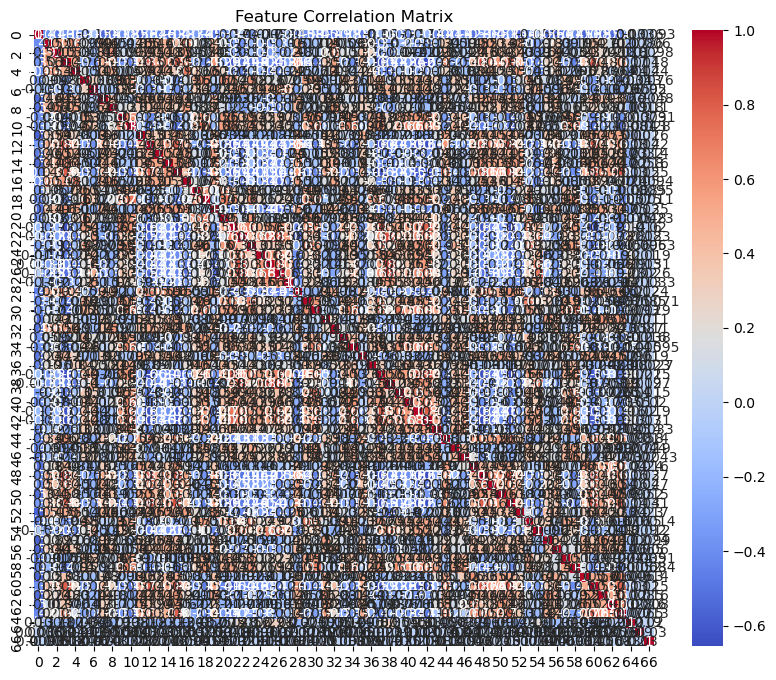

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pd.DataFrame(X_train1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Matrix")
plt.show()


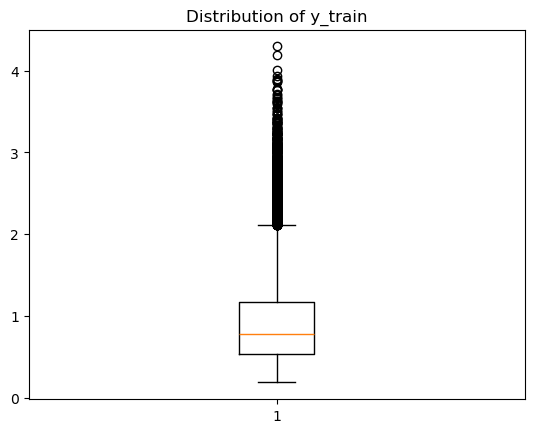

In [63]:
import matplotlib.pyplot as plt

plt.boxplot(y_train1)
plt.title("Distribution of y_train")
plt.show()


In [57]:
# Remove duplicated rows
unique_X_train, unique_indices = np.unique(X_train1, axis=0, return_index=True)
unique_y_train = y_train1[unique_indices]
X_train1, y_train1 = unique_X_train, unique_y_train


In [58]:
# Remove features with low variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1e-5)  # Remove features with very low variance
X_train1 = selector.fit_transform(X_train1)
X_test1 = selector.transform(X_test1)


In [59]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)  # Reduce to 30 meaningful components
X_train1 = pca.fit_transform(X_train1)
X_test1 = pca.transform(X_test1)


In [31]:
# log transformation
y_train1 = np.log1p(y_train1)
y_test1 = np.log1p(y_test1)


In [67]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

tree = DecisionTreeRegressor().fit(X_train1, y_train1)
importances = tree.feature_importances_

# Show top features
feature_importance_df = pd.DataFrame({"Feature": np.arange(len(importances)), "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df.head(10))


    Feature  Importance
10       10    0.089683
64       64    0.052015
34       34    0.046748
51       51    0.044047
59       59    0.041852
53       53    0.037987
66       66    0.034952
36       36    0.033306
33       33    0.030030
42       42    0.029873


In [76]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# 📌 1. Standardize the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train2)
X_val_scaled = scaler.transform(X_val2)
X_test_scaled = scaler.transform(X_test2)

# 📌 2. Define Ridge Regression Model
ridge = Ridge()

# 📌 3. Hyperparameter Tuning using GridSearchCV
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}  # Regularization strength
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train2)

# Get best alpha
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

# 📌 4. Train Ridge Model with Best Alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train2)

# 📌 5. Predict on Validation and Test Sets
y_val_pred = ridge_best.predict(X_val_scaled)
y_test_pred = ridge_best.predict(X_test_scaled)

# 📌 6. Evaluate Model Performance
mse_val = mean_squared_error(y_val2, y_val_pred)
r2_val = r2_score(y_val2, y_val_pred)

mse_test = mean_squared_error(y_test2, y_test_pred)
r2_test = r2_score(y_test2, y_test_pred)

print(f"Validation MSE: {mse_val:.4f}, R²: {r2_val:.4f}")
print(f"Test MSE: {mse_test:.4f}, R²: {r2_test:.4f}")


Best alpha: 100
Validation MSE: 0.3771, R²: 0.0214
Test MSE: 0.3752, R²: 0.0292


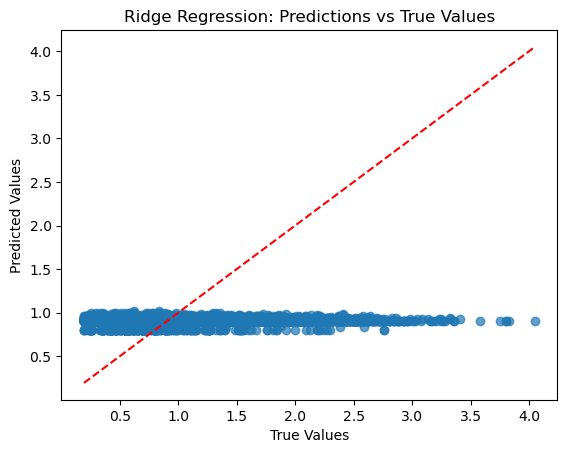

In [72]:
# Plot predictions vs true values
plt.scatter(y_test1, y_test_pred, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Predictions vs True Values")
plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)], color="red", linestyle="--")  # Diagonal line
plt.show()

**QUESTIONS**:
- The gene expression can be different for same gene in different cells? It does not just refer to a gene_id?
- How do we know what is the end site for the embedding count, is it the gene_end?
- Is in the embedding the chromosome also important?